In [ ]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import random

In [ ]:
pip install scikit-surprise

     |████████████████████████████████| 11.8MB 30.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617606 sha256=7080ffafbbbae94db5cb6a3d8c6e436782e21b939220de693e1bd83aa949c596
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import warnings
warnings.filterwarnings("ignore")

We will use the ratings dataset from the movielens datasets for this purpose. It contains the userId, movieId, rating. We dont need the timestamp column so we will drop that

In [ ]:
df_users = pd.read_csv("https://raw.githubusercontent.com/kushal134/CS419/main/ratings.csv")
df_users

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
df_users = df_users.drop(columns = ["timestamp"])

## **Exploratory Data Analysis**

---



Here we will examine and visualise our data and draw some conclusions. First, 
let us print the number of unique users and movies

In [ ]:
users = len(df_users["userId"].unique())
print(f"The number of users are {users}")

movies = len(df_users["movieId"].unique())
print(f"The number of movies are {movies}")

The number of users are 610
The number of movies are 9724


Now we will plot Ratings vs Count

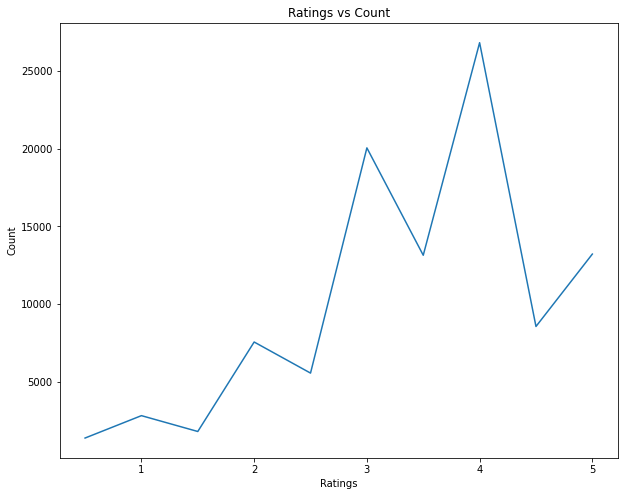

In [ ]:
user_data = df_users["userId"].value_counts()
user_data.values
rating_data = df_users["rating"].value_counts().sort_index()

plt.figure(figsize = (10,8))
plt.plot(rating_data.index,rating_data.values);
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.title("Ratings vs Count");

We see that most of the users have given a 4 star rating. More importantly, there is no heavy skewness in the data since there a considerable amount of 3 star and 5 star ratings, so we will let it be as it is.


Next we will look at the amount of movies rated by each user

In [ ]:
user_data = df_users["userId"].value_counts()
user_data

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

Text(0, 0.5, 'Count of users')

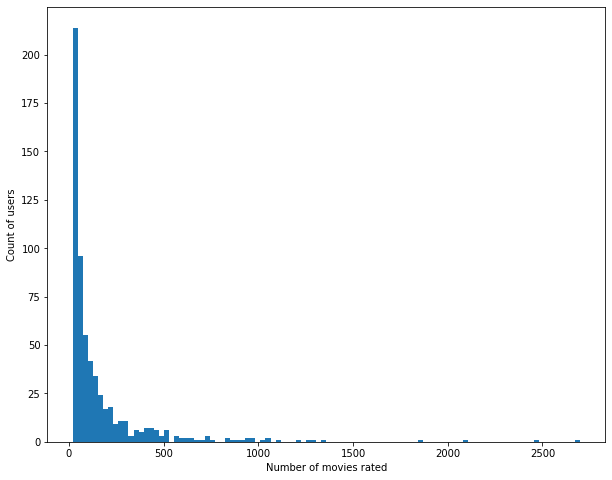

In [ ]:
plt.figure(figsize = (10,8))
plt.hist(user_data,bins = 100)
plt.xlabel("Number of movies rated")
plt.ylabel("Count of users")

In the above graph, The most productive user has rated 2698 movies whereas the several users have rated only 20 movies. We will filter out those users which have rarely rated movies to reduce the dimensionality of our dataset and to give better recommendations to other users


Lastly, we will focus on the movies and see how many times each movie has been rated.

In [ ]:
movie_data = df_users["movieId"].value_counts()
movie_data


356       329
318       317
296       307
593       279
2571      278
         ... 
5986        1
100304      1
34800       1
83976       1
8196        1
Name: movieId, Length: 9724, dtype: int64

Text(0, 0.5, 'Number of movies')

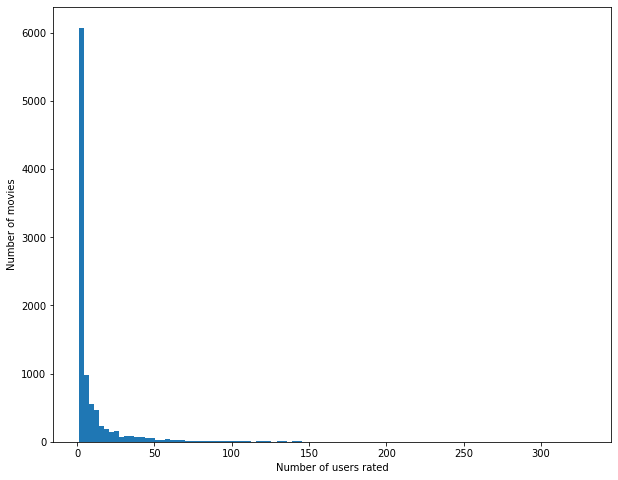

In [ ]:
plt.figure(figsize = (10,8))
plt.hist(movie_data,bins = 100)
plt.xlabel("Number of users rated")
plt.ylabel("Number of movies")

We see that the movie with ID 356 has been rated the most, by 329 users. Also, we see that close to 6000/9724 movies have been rated only once. These movies are not rated enough which might give inaccurate results and increase the dimensionality of our data.

So now, we will set a threshold on our movie ratings and user ratings and filter out those movies which have been rated less and those users which have been rated less. Since we will be proceeding with user - user based similarity in designing the algorithm from scratch, we will keep a stricter threshold for minimum user ratings (150). For minimum movie ratings, we dont want to be losing too much information so we keep the threshold at 75

In [ ]:
min_movie_ratings = 75
filter_movies = df_users['movieId'].value_counts() > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

min_user_ratings = 150
filter_users = df_users['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df_users[(df_users['movieId'].isin(filter_movies)) & (df_users['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df_users.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(100836, 3)
The new data frame shape:	(16836, 3)


In [ ]:
users_new = len(df_new["userId"].unique())
print(f"The number of users are {users_new}")

movies_new = len(df_new["movieId"].unique())
print(f"The number of movies are {movies_new}")

The number of users are 173
The number of movies are 230


We will split the cleaned dataset into train and test set (80-20% split). This is done using the scikit module.

In [ ]:
df_train, df_test = train_test_split(df_new, test_size=0.2, random_state=42)

In [ ]:
print(f"The entries in train set are {df_train.shape[0]} and the entries in test set are {df_test.shape[0]}")

The entries in train set are 13468 and the entries in test set are 3368


We are going to use user-user collaborative filtering for this purpose. Let us now define the pearson correlation which will calculate the similarity between two users. After calculating the similarity, we will recommend movies to the user which have been rated highly by the other users having similar interests.

The pearsons correlation is given by $$\frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum{(x_i - \bar{x})^2}\sum{(y_i - \bar{y})^2}}}$$

where $\bar{x}$ is the mean of all ratings given by user 1 and $\bar{y}$ is the mean of all ratings given by user 2 and we sum over all the ratings $x_i$ and $y_i$ which have been rated by **both the users**

In [ ]:
def pearson_coeff(i,j):
  #filter out the dataset of a particular user
  useri = df_train[df_train["userId"] == i]
  userj = df_train[df_train["userId"] == j]

  #merge the two datasets with movieId as the column, this will give us the common movies rated
  mergedStuff = pd.merge(useri, userj, on=['movieId'], how='inner')

  #take the mean of ratings given by both the users to all the movies
  meani = df_train[df_train["userId"] == i]["rating"].mean()
  meanj = df_train[df_train["userId"] == j]["rating"].mean()
  
  #calculate the pearson correlation
  num = ((mergedStuff['rating_x']-meani)*(mergedStuff['rating_y']-meanj)).sum()
  dem1 = ((mergedStuff['rating_x']-meani)**2).sum()
  dem2 = ((mergedStuff['rating_y']-meanj)**2).sum()
  
  result = num/np.sqrt(dem1*dem2)
  ###if they dont have any common movies rated, assume the users have the least similarity and assign -1
  if math.isnan(num/np.sqrt(dem1*dem2)):
    result = -1
  return result

Now we will store the list of users and movies in arrays so that these can be used to calculate the similarity matrix

In [ ]:
user_list = df_train["userId"].unique()
user_list_sort = user_list.sort()

In [ ]:
movie_list = df_train["movieId"].unique()


In [ ]:
p_coeff = np.zeros((610,610))
for i in user_list:
  for j in user_list:
      p_coeff[i-1][j-1] = pearson_coeff(i,j)

Let us now define the prediction function which will take in a user id and a movie id and give a predicted movie rating which the user will give to the movie. We will then compare these predictions with our test set

In [ ]:
def prediction(uid, mid):
  #we will chose 50 nearest neighbours, and take the weighted mean of the movie ratings with weights as similarity coefficients 
  arr = p_coeff[uid - 1] #this is to take the similarity row of the user with all the other users
  #note that we have to subtract 1 since indexing in the similarity matrix p coeff starts from 1
  
  sim = arr
  arr_copy = arr
  
  k_neighb = arr_copy.argsort()[-50:][::-1] #find the 50 nearest neighbours (list of users)
  

  #now if the each neighbour in the 50 neighbours have rated the movie, we will take the weighted mean and generate the predicted rating
  num = 0
  dem = 0
  count = 0
  #Now we loop over the 50 nearest neighbours
  for i in k_neighb.flatten():
    movies = df_train[df_train["userId"] == i + 1]["movieId"].unique() #add 1 to the index, this will give the list of movies the user has rated
    #if the user has rated the movie, take the weighted average
    if mid in movies:
      #extract the rating given by the user
      b = df_train[df_train["userId"] == i + 1]
      a = b[b["movieId"] == mid]["rating"].iloc[0]
      
      num += sim[i]*a
      dem += sim[i]
      
      count += 1

  result = num/dem
  #For nan case
  if math.isnan(num/dem):
    result = random.randint(1,5)

  return(result)


In [ ]:
df_test

,userId,movieId,rating
68746,448,587,3.0
4326,28,1732,4.0
54007,356,5445,3.5
41991,287,1101,0.5
43199,290,50,4.0
...,...,...,...
50370,325,2987,3.0
41081,279,608,2.0
5699,41,1732,4.0
65922,425,364,3.0


Let us now make the predictions!
We will store the results in predict array and the error in the error array and then calculate the rmse error

In [ ]:
results = []
error = []
for lines in df_test.itertuples():
  predict = prediction(lines[1],lines[2])
  results.append(predict)
  error.append(predict - lines[3])



We get a pretty decent rmse error. Using the surprise library we will try to reduce this error (using item-item based collaboritive filtering)

In [ ]:
error_arr = np.array(error)
np.sqrt((error_arr**2).sum()/df_test.shape[0])

0.8558684117914319

In [ ]:
prediction(1, 1036)

3.74566649132904

In [ ]:
pip install scikit-surprise

## **Collaborative Filtering using Surprise Library**


---

After developing the collaborative filtering algorithm from scratch, we will now take a look at the python library Surprise which is specially built to design recommendation systems. First, we will test a variety of algorithms on the uncleaned dataset vs the cleaned dataset. We expect the error to be better in case of the cleaned dataset due to the reasons mentioned above. 

Next, we will focus on 2 algorithms, discuss in brief the implemenation of those algorithms and then test those 2 on our movie lens dataset

In [ ]:
#import the necessart libraries

from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import SVD,KNNBaseline, KNNBasic, KNNWithMeans, BaselineOnly
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [ ]:
pip freeze requirements.txt

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.2
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.2
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
cftime==1.4.1
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.23
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
dlib==19.18.0
dm-tree==0.1.6
docopt

In [ ]:
#we will need a reader class to be supplied while loading the data frame
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_users[['userId', 'movieId', 'rating']], reader)

In [ ]:
algo_list_df = ["SVD", "KNNBaseline", "KNNBasic", "KNNWithMeans", "BaselineOnly"]

We first cross validate the algorithms on our uncleaned dataset, we will use the KFold cross validation technique (2 fold) and append the mean of the results in a dataframe

In [ ]:
results = []
algo_list = [SVD(), KNNBaseline(), KNNBasic(), KNNWithMeans(), BaselineOnly()]


for algo in algo_list:
  results.append(cross_validate(algo, data, measures=['RMSE'], cv=2, verbose=False))

#store the results in a dataframe
df_results = pd.DataFrame()
for result in results:
  df_result = pd.DataFrame().from_dict(result).mean(axis = 0)
  df_results = df_results.append(df_result,ignore_index = True)

df_results["Algorithm"] = algo_list_df  
df_results

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...


,fit_time,test_rmse,test_time,Algorithm
0,3.119480,0.890254,0.586830,SVD
1,0.324431,0.893365,4.169534,KNNBaseline
2,0.080433,0.973299,2.976797,KNNBasic
3,0.099785,0.918421,3.339216,KNNWithMeans
4,0.263875,0.884732,0.408413,BaselineOnly


Next, we will take a look at the cleaned dataset and perform the exact same process

In [ ]:
data_new = Dataset.load_from_df(df_new[['userId', 'movieId', 'rating']], reader)
results_new = []
for algo in algo_list:
  results_new.append(cross_validate(algo, data_new, measures=['RMSE'], cv=2, verbose=False))

df_results_new = pd.DataFrame()
for result in results_new:
  df_result_new = pd.DataFrame().from_dict(result).mean(axis = 0)
  df_results_new = df_results_new.append(df_result_new,ignore_index = True)


df_results_new["Algorithm"] = algo_list_df
df_results_new

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...


,fit_time,test_rmse,test_time,Algorithm
0,0.495881,0.809825,0.088601,SVD
1,0.028699,0.804044,0.927727,KNNBaseline
2,0.019455,0.863818,0.647953,KNNBasic
3,0.025250,0.806048,0.709248,KNNWithMeans
4,0.022275,0.810487,0.040120,BaselineOnly


As expected, we clearly notice that the refined dataframes significantly perform better for all algorithms. This is the advantage provided to us by cleaning the data. The disadvantage is that the number of movies and users have reduced significantly which will bring limitations to what we can predict for a new user or a movie. 

Depending on the condition, we can opt for either case. In this notebook we will use the cleaned data (df_new) and proceed with the Baseline and KNNwithmeans algorithms. These 2 algorithms are significantly different in the process which they follow

We will perform a grid search on this algorithm to chose the best hyperparameters

# **Baseline estimate**


---
Some movies may recieve higher ratings than other and some users might rate higher than others. It is customary to adjust the data by accounting for
these effects, which we encapsulate within the **baseline estimates**. 
Let
$\mu$ be the overall average rating. A baseline estimate for an unknown rating $r_{ui}$ is $$ b_{ui} = \mu + b_{u} + b_{i} $$ where $b_u$ accounts for user effects and $b_i$ accounts for item(movie) effects. This now becomes a standard regression problem and to solve we minimise the least square error (with regularisation) given by
$$min \sum_{u,i} (r_{ui} - (\mu + b_{u} + b_{i}))^2 + \lambda_1(\sum_u b_u^2 + \sum_i b_i^2)$$

This is implemented using grid search where we tune the hyperparameters to yield the best result

In [ ]:
param_grid = {'bsl_options': {'method': ['als'],'n_epochs': [2,5,8,10,],'reg_u': [5,10,20,30],'reg_i': [8,15,30]}}
                              
gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse', 'mae'], cv=5,joblib_verbose=0);

gs.fit(data_new);

In [ ]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.7970298974307413
{'bsl_options': {'method': 'als', 'n_epochs': 10, 'reg_u': 5, 'reg_i': 8}}


In [ ]:
trainset, testset = train_test_split(data_new, test_size=0.20)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.7993


0.799301581538504

In [ ]:
results_df_baseline = pd.DataFrame.from_dict(gs.cv_results)
pd.set_option('display.max_colwidth', 100)
results_df_baseline.style.set_properties(subset=['params'], **{'width': '500px'})
results_df_baseline[["mean_test_rmse","rank_test_rmse",'params']].sort_values("rank_test_rmse")


,mean_test_rmse,rank_test_rmse,params
36,0.797030,1,"{'bsl_options': {'method': 'als', 'n_epochs': 10, 'reg_u': 5, 'reg_i': 8}}"
24,0.797032,2,"{'bsl_options': {'method': 'als', 'n_epochs': 8, 'reg_u': 5, 'reg_i': 8}}"
12,0.797039,3,"{'bsl_options': {'method': 'als', 'n_epochs': 5, 'reg_u': 5, 'reg_i': 8}}"
0,0.797087,4,"{'bsl_options': {'method': 'als', 'n_epochs': 2, 'reg_u': 5, 'reg_i': 8}}"
39,0.797823,5,"{'bsl_options': {'method': 'als', 'n_epochs': 10, 'reg_u': 10, 'reg_i': 8}}"
27,0.797824,6,"{'bsl_options': {'method': 'als', 'n_epochs': 8, 'reg_u': 10, 'reg_i': 8}}"
15,0.797828,7,"{'bsl_options': {'method': 'als', 'n_epochs': 5, 'reg_u': 10, 'reg_i': 8}}"
3,0.797872,8,"{'bsl_options': {'method': 'als', 'n_epochs': 2, 'reg_u': 10, 'reg_i': 8}}"
37,0.798921,9,"{'bsl_options': {'method': 'als', 'n_epochs': 10, 'reg_u': 5, 'reg_i': 15}}"
25,0.798926,10,"{'bsl_options': {'method': 'als', 'n_epochs': 8, 'reg_u': 5, 'reg_i': 15}}"


# **KNN with means**


---
Now we will look at a different approach, which was similar to what we implemented from scratch, only with a few minor differences. There are mainly 2 types of sub categories in this algorithm:


1.   **User - User based** - Estimate unknown ratings based on recorded ratings of like-minded users
2.   **Item - Item based** - A rating is estimated using known ratings
made by the same user on similar items.

We will focus on the second one (the reasons are discussed later)

The rating $\hat{r_{ui}}$ which is the predicted rating given by user $u$ to item $i$ is given by $$\hat{r_{ui}} = \mu_i + \frac{\sum_j sim(i,j) \cdot (r_{uj} - \mu_{j})}{\sum_j sim(i,j)} $$ where j are the items belonging to the neighbourhood of i (ie having the highest similarity) and $\mu_i$ and $\mu_j$ are the mean ratings received for those items.

The advantage of item-item based filtering is that Item-item neighborhood models can provide updated recommendations immediately after users enter new ratings. This includes handling new users as soon as they provide feedback to the system, without needing to retrain the model and estimate new parameters. (we assume that the item - item similarity is stable over time)

Also, we note that we implemented the basic KNN algorithm from scratch which is slightly different from the KNN with means and as the name suggests, a basic version. Here, we dont bother about the mean average ratings given to an item (movie). We simply take the weighted average of the ratings given to the movie by similar users (user - user based) or the ratings given different similar movies by the same user (item - item based). We had implemented user - user based collaborative filtering. Mathematically, it is given by $$\hat{r_{ui}} = \frac{\sum_v sim(u,v) \cdot r_{vi}}{\sum_v sim(u,v)} $$ where $v$ are the similar users to user $u$


Here we will again do a grid search to determine the best parameters for our algorithm. The first parameter is the similarity measure where we give 3 choices (one of them is the pearson baseline which was implemented previously). Then we also provide minimum support, that is the minimum number of common items or users for the similarity not to be 0. Suppose in user - user based, 2 users have only 3 items in common and if our minimum support is 0, then the similarity between the two users will be 0. We had implemented something similar in the previous algorithm where our minimum support was 0 (to prevent nan values). The last argument is the user_based option. True implies user - user based and false implies item - item based. As suggested  above, we will see that item - item based is a better collaborative filtering algorith

In [ ]:
param_grid = {
              'sim_options': {'name': ['msd', 'cosine','pearson_baseline'],
                              'min_support': [1, 5, 10],
                              'user_based': [True, False]}
              }
                              
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5,joblib_verbose=0);

gs.fit(data_new);

In [ ]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.7664851583164056
{'sim_options': {'name': 'pearson_baseline', 'min_support': 1, 'user_based': False}}


We will now print the dataframe consisting of the parameters and the test rmse. Firstly, we notice that item - item based gives better rmse than user - user based. Secondly, we see that **pearson baseline** is the best similarity measurement and lastly, we see that a suitable minimum support is somewhere in the middle (5)

In [ ]:

results_df_knn = pd.DataFrame.from_dict(gs.cv_results)
pd.set_option('display.max_colwidth', 100)
results_df_knn.style.set_properties(subset=['params'], **{'width': '500px'})
results_df_knn[["mean_test_rmse","rank_test_rmse",'params']]

,mean_test_rmse,rank_test_rmse,params
0,0.792811,14,"{'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': True}}"
1,0.781277,8,"{'sim_options': {'name': 'msd', 'min_support': 1, 'user_based': False}}"
2,0.792805,13,"{'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': True}}"
3,0.781270,7,"{'sim_options': {'name': 'msd', 'min_support': 5, 'user_based': False}}"
4,0.793189,15,"{'sim_options': {'name': 'msd', 'min_support': 10, 'user_based': True}}"
5,0.780841,4,"{'sim_options': {'name': 'msd', 'min_support': 10, 'user_based': False}}"
6,0.793601,16,"{'sim_options': {'name': 'cosine', 'min_support': 1, 'user_based': True}}"
7,0.788315,11,"{'sim_options': {'name': 'cosine', 'min_support': 1, 'user_based': False}}"
8,0.793658,17,"{'sim_options': {'name': 'cosine', 'min_support': 5, 'user_based': True}}"
9,0.788318,12,"{'sim_options': {'name': 'cosine', 'min_support': 5, 'user_based': False}}"


Here we see that pearson baseline is the best similarity measure along with item-item based similarity which gives better result over user-user based similarity as discussed above (to be added)

In [ ]:
algo = gs.best_estimator['rmse']
trainset, testset = train_test_split(data_new, test_size=0.20)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.7511


0.7510675776201968

In [ ]:
uid = trainset.to_raw_uid(1)  # raw user id (as in the ratings file). They are **strings**!
iid = trainset.to_raw_iid(59)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
algo.test([[uid,iid,None]])

# predictions[2873]

[Prediction(uid=182, iid=1208, r_ui=None, est=4.592138958801601, details={'actual_k': 40, 'was_impossible': False})]

In [ ]:
predictions[:4]

[Prediction(uid=169, iid=1097, r_ui=4.0, est=4.584244763492519, details={'actual_k': 38, 'was_impossible': False}),
 Prediction(uid=434, iid=208, r_ui=2.5, est=2.896407540564421, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=232, iid=59315, r_ui=4.5, est=3.977069073113711, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=307, iid=5618, r_ui=4.0, est=3.7538878833202824, details={'actual_k': 40, 'was_impossible': False})]

In [ ]:
trainset.ur

defaultdict(list,
            {0: [(0, 1.0),
              (35, 2.5),
              (81, 5.0),
              (144, 1.0),
              (150, 5.0),
              (34, 3.0),
              (179, 3.0),
              (64, 3.0),
              (75, 5.0),
              (82, 5.0),
              (99, 4.0),
              (158, 5.0),
              (138, 5.0),
              (113, 5.0),
              (83, 4.0),
              (169, 5.0),
              (9, 2.0),
              (173, 2.0),
              (16, 2.0),
              (91, 2.0),
              (26, 4.0),
              (207, 1.5),
              (153, 5.0),
              (196, 3.0),
              (10, 2.0),
              (38, 4.0),
              (94, 4.0),
              (100, 1.0),
              (187, 2.0),
              (49, 5.0),
              (116, 2.0),
              (118, 5.0),
              (58, 5.0),
              (194, 1.0),
              (214, 2.0),
              (19, 4.0),
              (198, 4.0),
              (62, 2.0),
             